# Create a dataset class to work in PyTorch

In [1]:
import random
import pickle
import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Retrieve  patch extraction functions

Slightly modifed to optimise torch operation or remove useless features

In [7]:
def extract_patches(img, img_mask, patch_size, nb_patch, rnd=0, debug=False):
    patches = []
    
    img_shape = img.shape
    
    # If the patch is too big, extract a smaller one
    reduction_ratio = 1
    while patch_size >= img_shape[0]//2 or patch_size >= img_shape[1]//2:
        patch_size //= 2
        reduction_ratio *= 2
    
    # Do not extract on the border
    img_mask[:, :int(patch_size/2)] = 0
    img_mask[:int(patch_size/2), :] = 0
    img_mask[int(-patch_size/2):, :] = 0
    img_mask[:, int(-patch_size/2):] = 0
    
    # Select uniformly (+ some noise) the position of the extracted patches
    x_line = np.linspace(start=patch_size//2+1, stop=img_shape[1]-patch_size-1, num=nb_patch)
    x_line += (patch_size//2-1)*(np.random.rand(nb_patch))
    
    if debug:
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=cm.gray)
        proba_dist_plt = np.copy(img_mask)
        proba_dist_plt = 255*proba_dist_plt/np.max(proba_dist_plt)
        proba_dist_plt[proba_dist_plt>0] = 255
        ax.imshow(proba_dist_plt, cmap=cm.gray, interpolation='none', alpha=0.5)
        ax.set_title("Proba distribution")
            
    for i in range(0, nb_patch):
        width_pos = int(x_line[i])
        proba_line = img_mask[:,width_pos].numpy() # for some reason choice does not work with tensor
        
        if random.random() < rnd:
            height_pos = patch_size//2+1+int((img_shape[0]-patch_size-1)*random.random())
        else:
            if np.sum(proba_line)  == 0:
                height_pos = patch_size//2+1+int((img_shape[0]-patch_size-1)*random.random())
            else:
                proba_line /= np.sum(proba_line)
                height_pos = np.random.choice(img_shape[0], p=proba_line)

        if debug:
            plt.plot(width_pos, height_pos, 'ro')
            plt.vlines(width_pos, 0, img_shape[0]-1, colors="red", linestyles="--")

        extracted_patch = img[int(height_pos-patch_size/2):int(height_pos+patch_size/2), 
                                        int(width_pos-patch_size/2):int(width_pos+patch_size/2)]
        
        if reduction_ratio != 1:
            resizer = transforms.Resize(extracted_patch.shape[0]*reduction_ratio)
            extracted_patch = resizer(extracted_patch.unsqueeze(0).unsqueeze(0))[0,0,:,:]
        
        patches.append(extracted_patch)
        
    if debug:
        plt.title("Patches center position")
        plt.show()
        
    if debug:
        fig, axs = plt.subplots(1, nb_patch)
        for i, patch in enumerate(patches):
            axs[i].imshow(patch, cmap="gray")
            axs[i].set_axis_off()
        fig.tight_layout()
        fig.show()
        plt.show()
        
    return patches

# Extend images and mask

In [8]:
def extend_images(img, img_mask, train_configuration, test=False):
    # Some operations need RGB images
    img = img.repeat(3, 1, 1)
    img_mask = img_mask.repeat(3, 1, 1)
    
    if train_configuration["normalise"]:
        mean, std = 0.44531356896770125, 0.2692461874154524 # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        img = TF.normalize(img, [mean], [std])
        img_mask = TF.normalize(img_mask, [mean], [std])

    if test is False: # only extend images when training
        if train_configuration["random_crop"] is not None:
            if random.random() < train_configuration["random_crop"]:
                x, y, h, w = transforms.RandomResizedCrop.get_params(img, ratio=(0.9,1.1), scale=(0.9, 1))
                img = TF.resized_crop(img, x, y, h, w, size=(img.shape[1], img.shape[2]))
                img_mask = TF.resized_crop(img_mask, x, y, h, w, size=(img.shape[1], img.shape[2]))

        if train_configuration["gaussian_blur"] is not None:
            if random.random() < train_configuration["gaussian_blur"]:
                sigma = transforms.GaussianBlur.get_params(0.001, 0.01)
                img = TF.gaussian_blur(img, kernel_size=(3, 3), sigma=sigma)
                img_mask = TF.gaussian_blur(img_mask, kernel_size=(3, 3), sigma=sigma)

        if train_configuration["random_rotation"] is not None:
            if random.random() < train_configuration["random_rotation"]:
                angle = transforms.RandomRotation.get_params(degrees=[-2,2])
                img = TF.rotate(img, angle)
                img_mask = TF.rotate(img_mask, angle)


    img = img[0, :, :]
    img_mask = img_mask[0, :, :]
                
    return img, img_mask

# Define the  dataset class

In [9]:
class AttentionDataset():
    def __init__(self, df, basepath, train_configuration, test, debug=False):
        self.df = df
        self.patient_names = df.index.get_level_values('patient_name').to_series().unique()
        self.basepath = basepath
        
        self.train_configuration = train_configuration
        self.patch_size_l = train_configuration["patch_size_l"]
        self.nb_patch_l = train_configuration["nb_patch_l"]
        self.rnd=train_configuration["rnd"]
        
        self.test = test
        
    def __len__(self):
        return len(self.patient_names)

    def __getitem__(self,idx):
        patient_name = self.patient_names[idx]
        
        available_arteries = torch.load(basepath+"/"+patient_name+"/available_arteries.pt")
        mi = torch.load(basepath+"/"+patient_name+"/global_mi.pt")
        
        all_patches = [[[] for k in range(0,2)] for i in range(0,3)]
        
        for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
            for i_view, view in enumerate(["view1", "view2"]):
                if available_arteries[i_artery]:
                    for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):
                        box = torch.load(self.basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_box.pt")
                        centerline = torch.load(self.basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_centerline.pt")

                        plt.imshow(box, cmap="gray")
                        plt.title("Box of Artery {} view {} section {}".format(artery, view, section))
                        plt.show()

                        plt.imshow(centerline, cmap="gray")
                        plt.title("Centerline of Artery {} view {} section {}".format(artery, view, section))
                        plt.show()

                        box, centerline = extend_images(box, centerline, self.train_configuration, test=self.test)

                        plt.imshow(box, cmap="gray")
                        plt.title("Box of Artery {} view {} section {} after extension".format(artery, view, section))
                        plt.show()

                        plt.imshow(centerline, cmap="gray")
                        plt.title("Centerline of Artery {} view {} section {} after extension".format(artery, view, section))
                        plt.show()

                        if not all_patches[i_artery][i_view]:
                            all_patches[i_artery][i_view] = extract_patches(box,  centerline, 
                                                                 self.patch_size_l[i_sect], self.nb_patch_l[i_sect], 
                                                                 rnd=self.rnd)
                            
                        else:
                            all_patches[i_artery][i_view] += extract_patches(box,  centerline, 
                                                                 self.patch_size_l[i_sect], self.nb_patch_l[i_sect], 
                                                                 rnd=self.rnd)

                    all_patches[i_artery][i_view] = torch.stack(all_patches[i_artery][i_view], dim=0)
                else:
                    # !! ASSUME SAME PATCH SIZE HERE
                    tot_len = 0
                    for size in self.nb_patch_l:
                        tot_len += size
                    all_patches[i_artery][i_view] = torch.zeros((tot_len, self.patch_size_l[0], self.patch_size_l[0]))
        
        lad = (all_patches[0][0].unsqueeze(1), 
               all_patches[0][1].unsqueeze(1))
        lcx = (all_patches[1][0].unsqueeze(1), 
               all_patches[1][1].unsqueeze(1))        
        rca = (all_patches[2][0].unsqueeze(1),
               all_patches[2][1].unsqueeze(1))
        
        return available_arteries, (lad, lcx, rca), mi

# Test it

In [5]:
train_configuration = {
    "patch_size_l": [64, 64, 64, 64],
    "nb_patch_l": [8, 8, 16, 16],
    "rnd": 0.2,
    "gaussian_blur": 1,
    "normalise":  False,
    "random_rotation": 1,
    "random_crop": 1,
}

pkl_file = open('transformer_df.pkl', 'rb')
region_level_df_boxes_complete = pickle.load(pkl_file)
basepath = "transformer_patient_torch_tensors"

dataset = AttentionDataset(region_level_df_boxes_complete, basepath, train_configuration, test=False, debug=False)

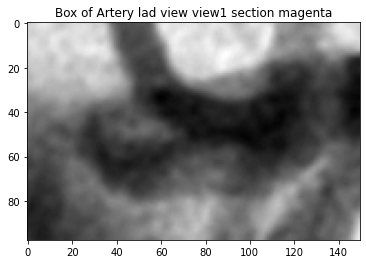

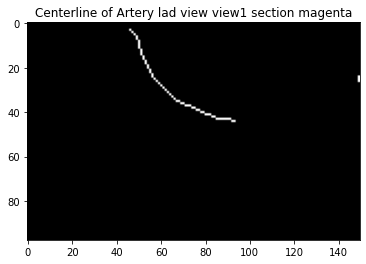

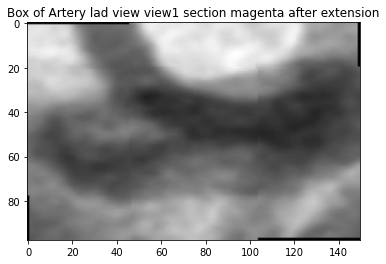

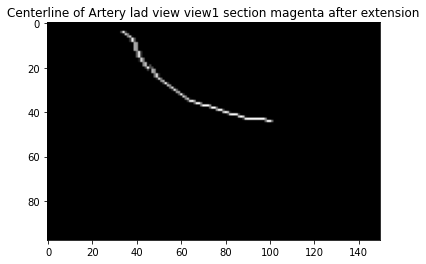

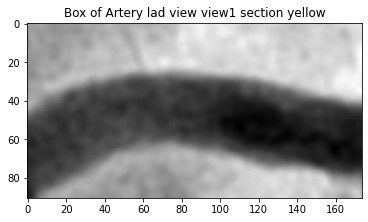

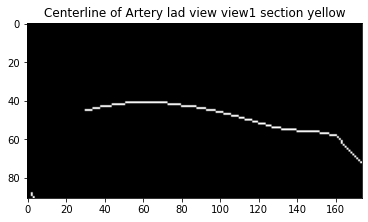

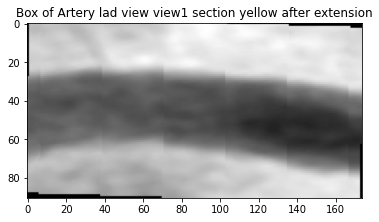

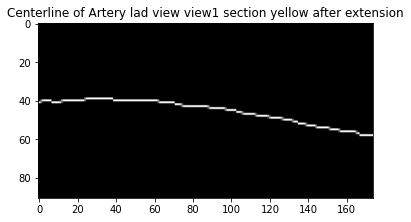

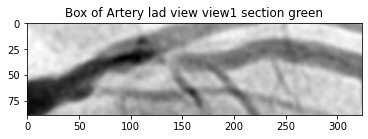

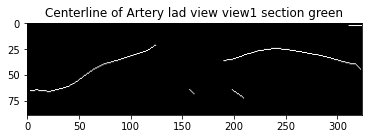

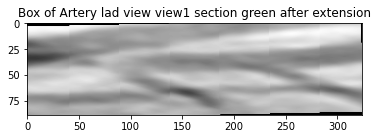

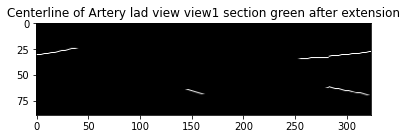

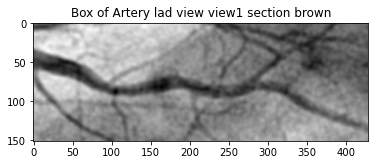

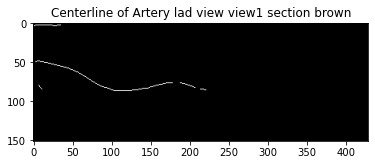

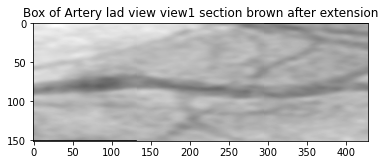

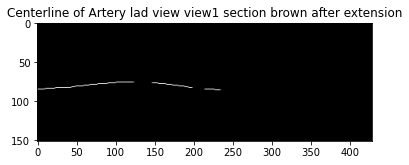

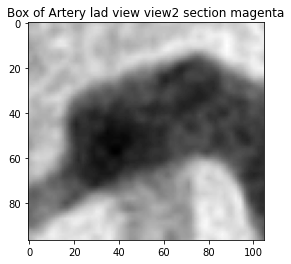

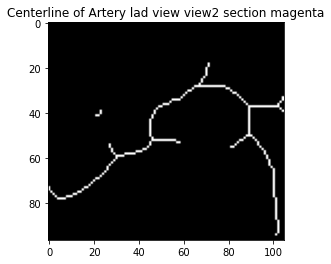

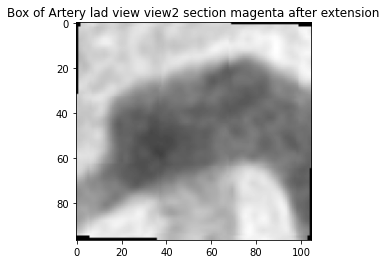

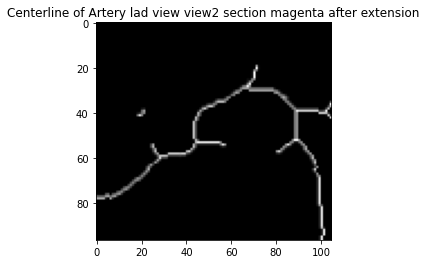

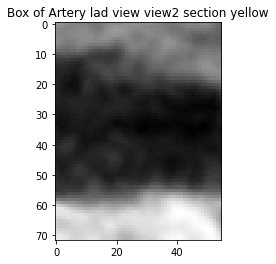

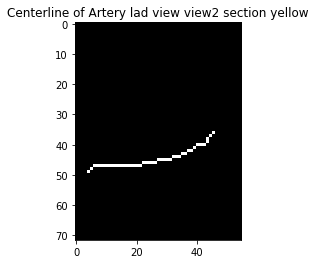

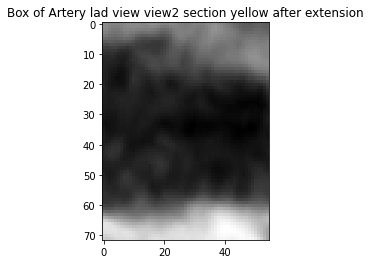

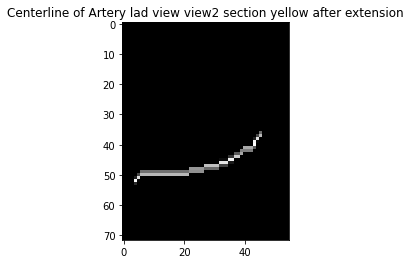

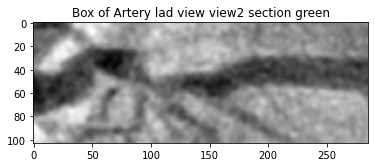

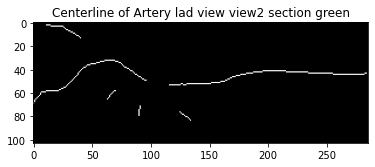

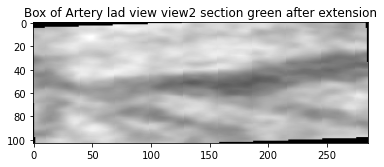

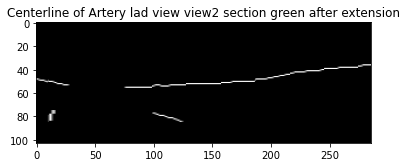

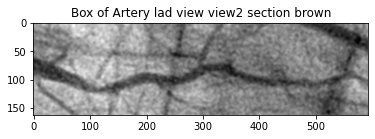

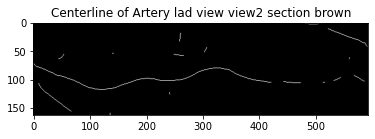

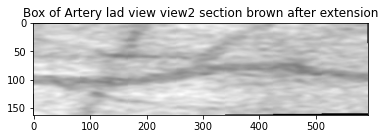

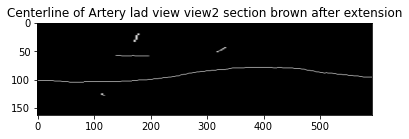

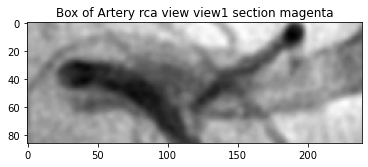

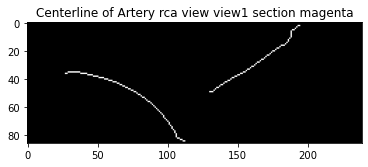

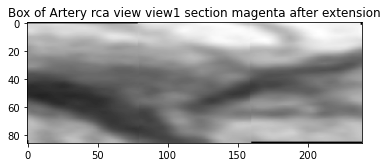

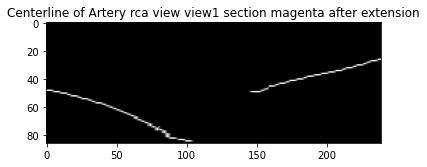

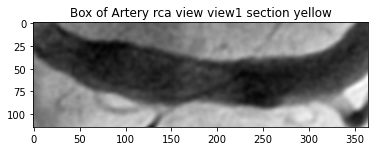

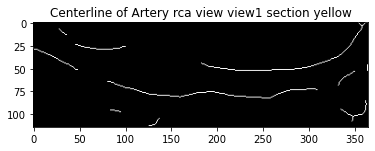

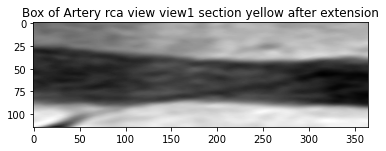

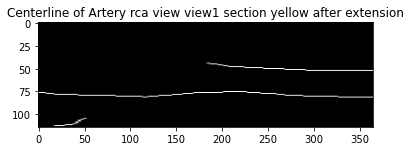

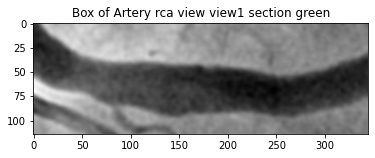

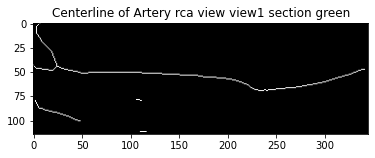

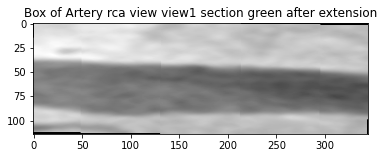

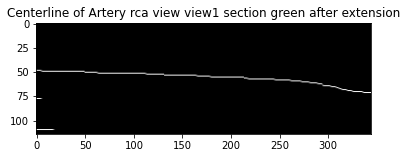

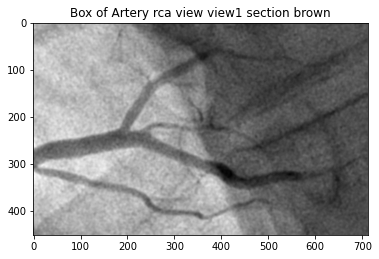

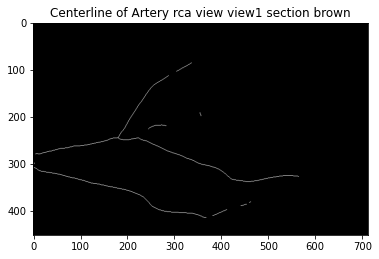

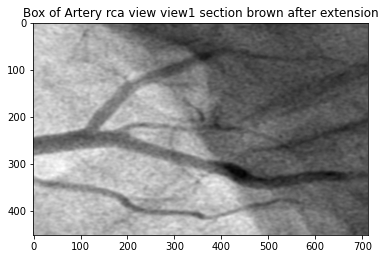

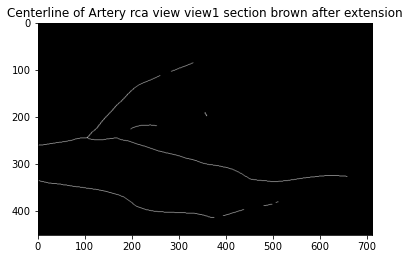

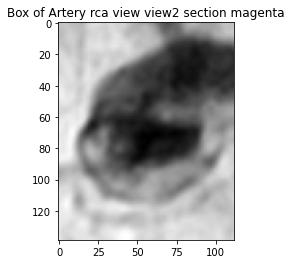

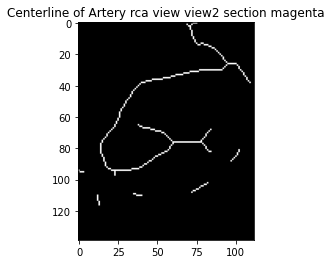

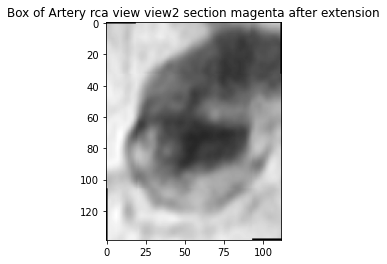

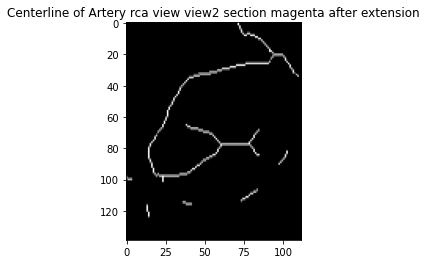

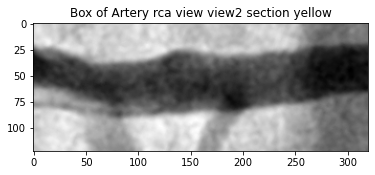

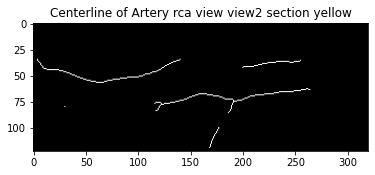

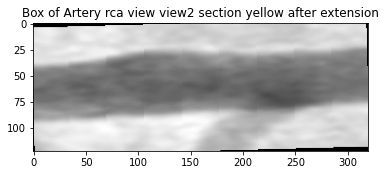

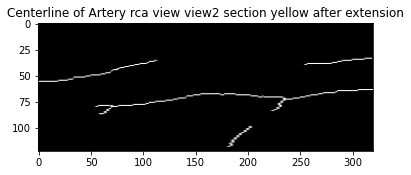

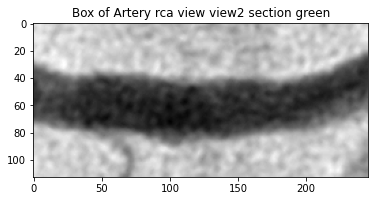

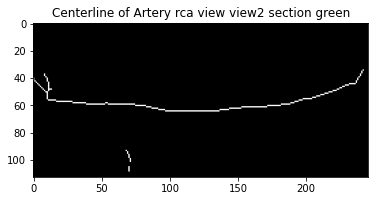

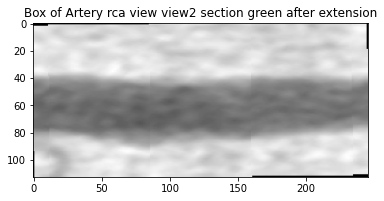

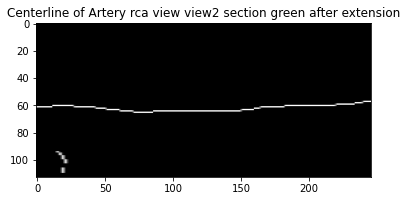

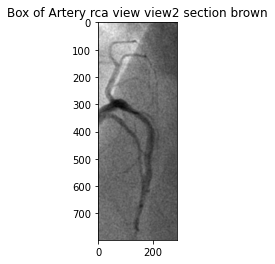

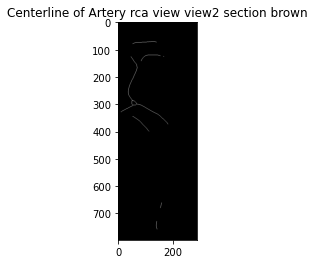

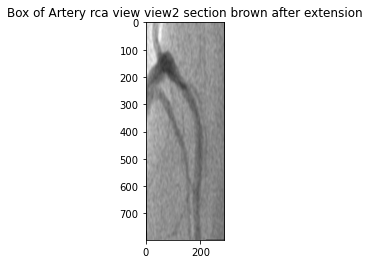

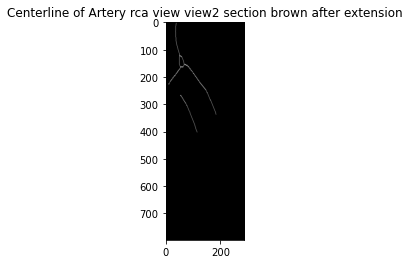

In [6]:
available_arteries, patches, mi = dataset.__getitem__(0)



Artery LAD view 0:



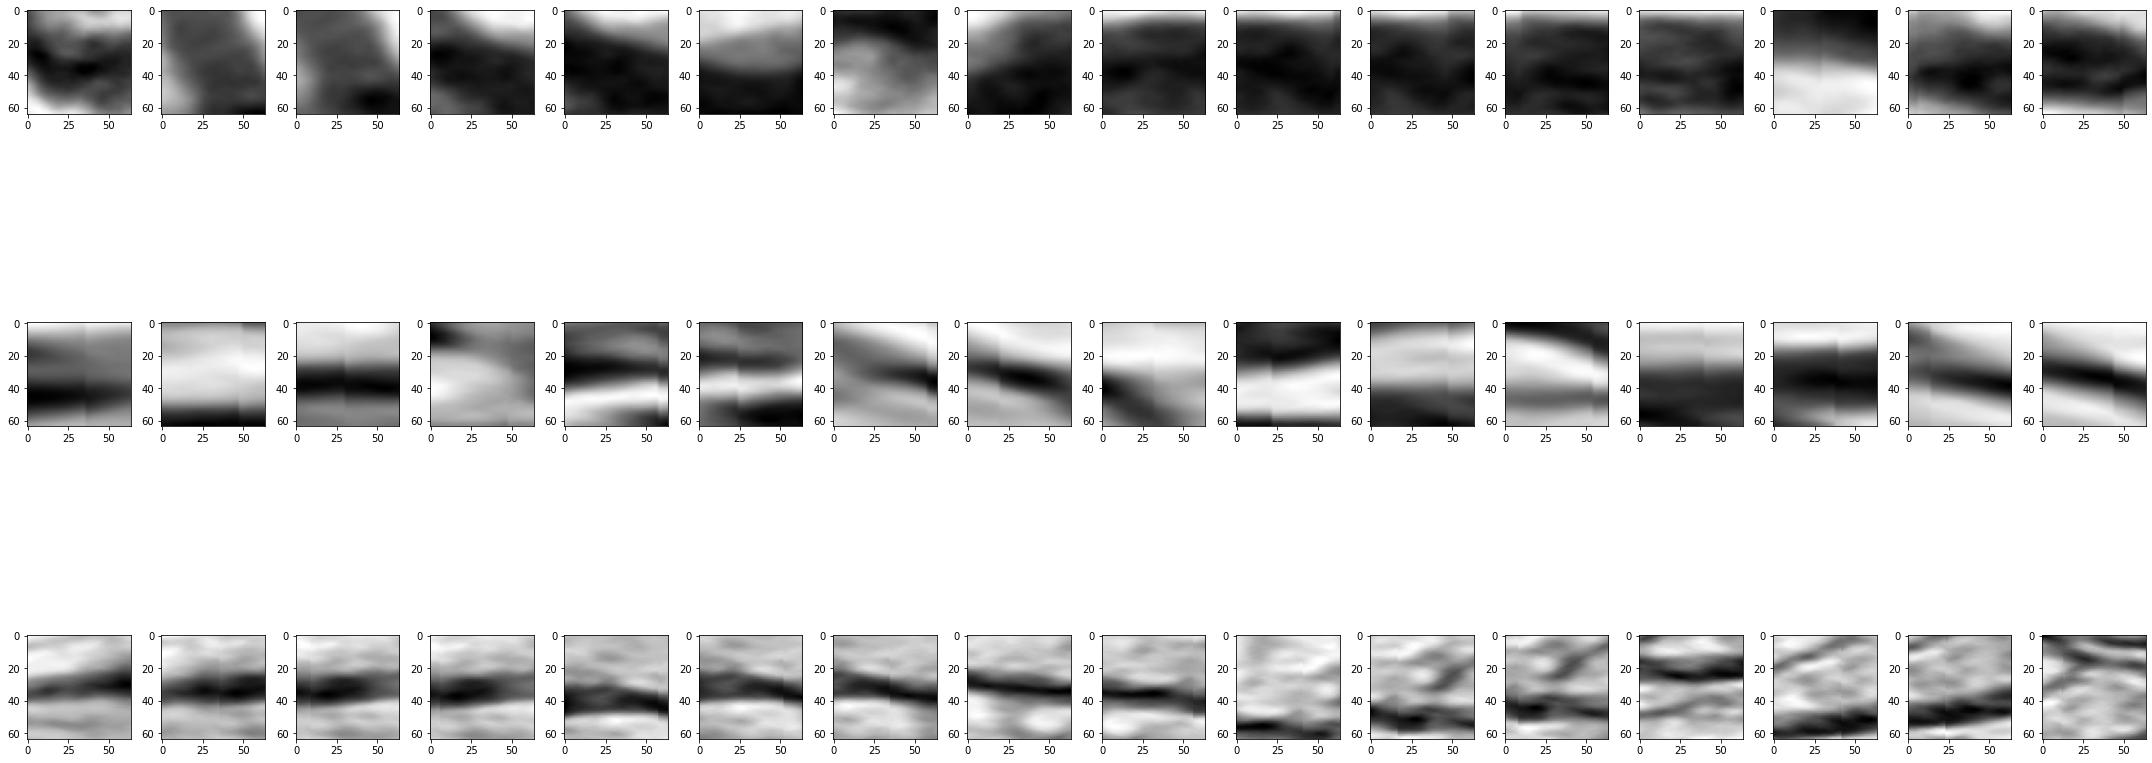



Artery LAD view 1:



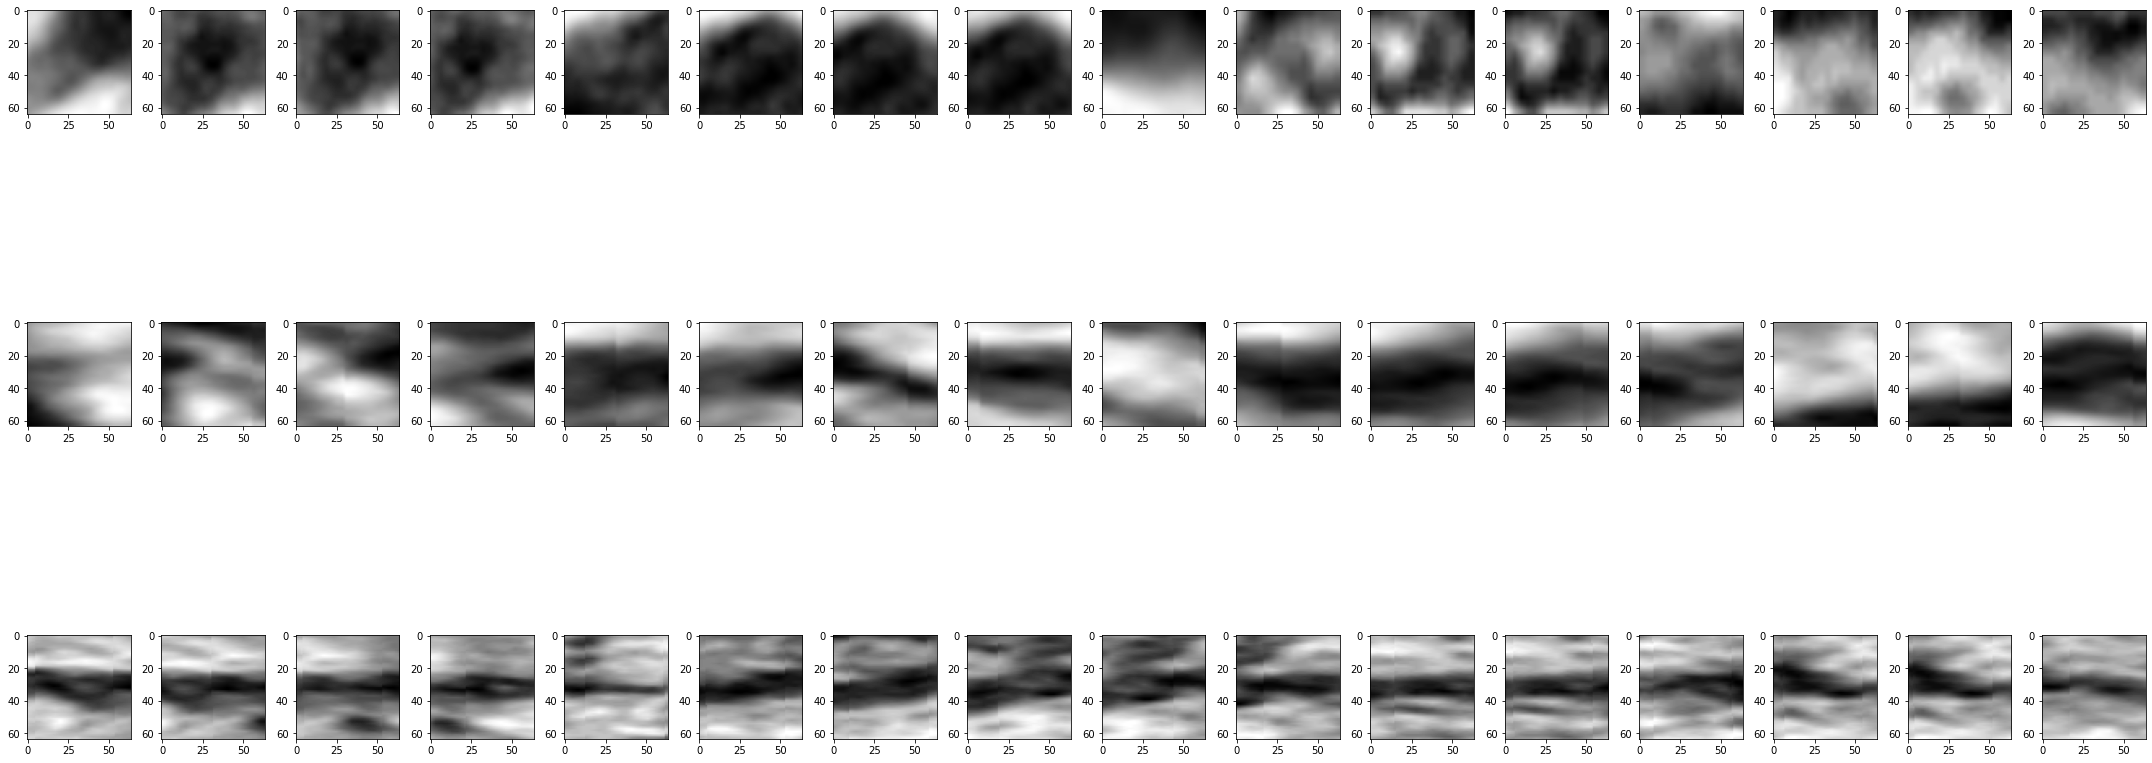



Artery RCA view 0:



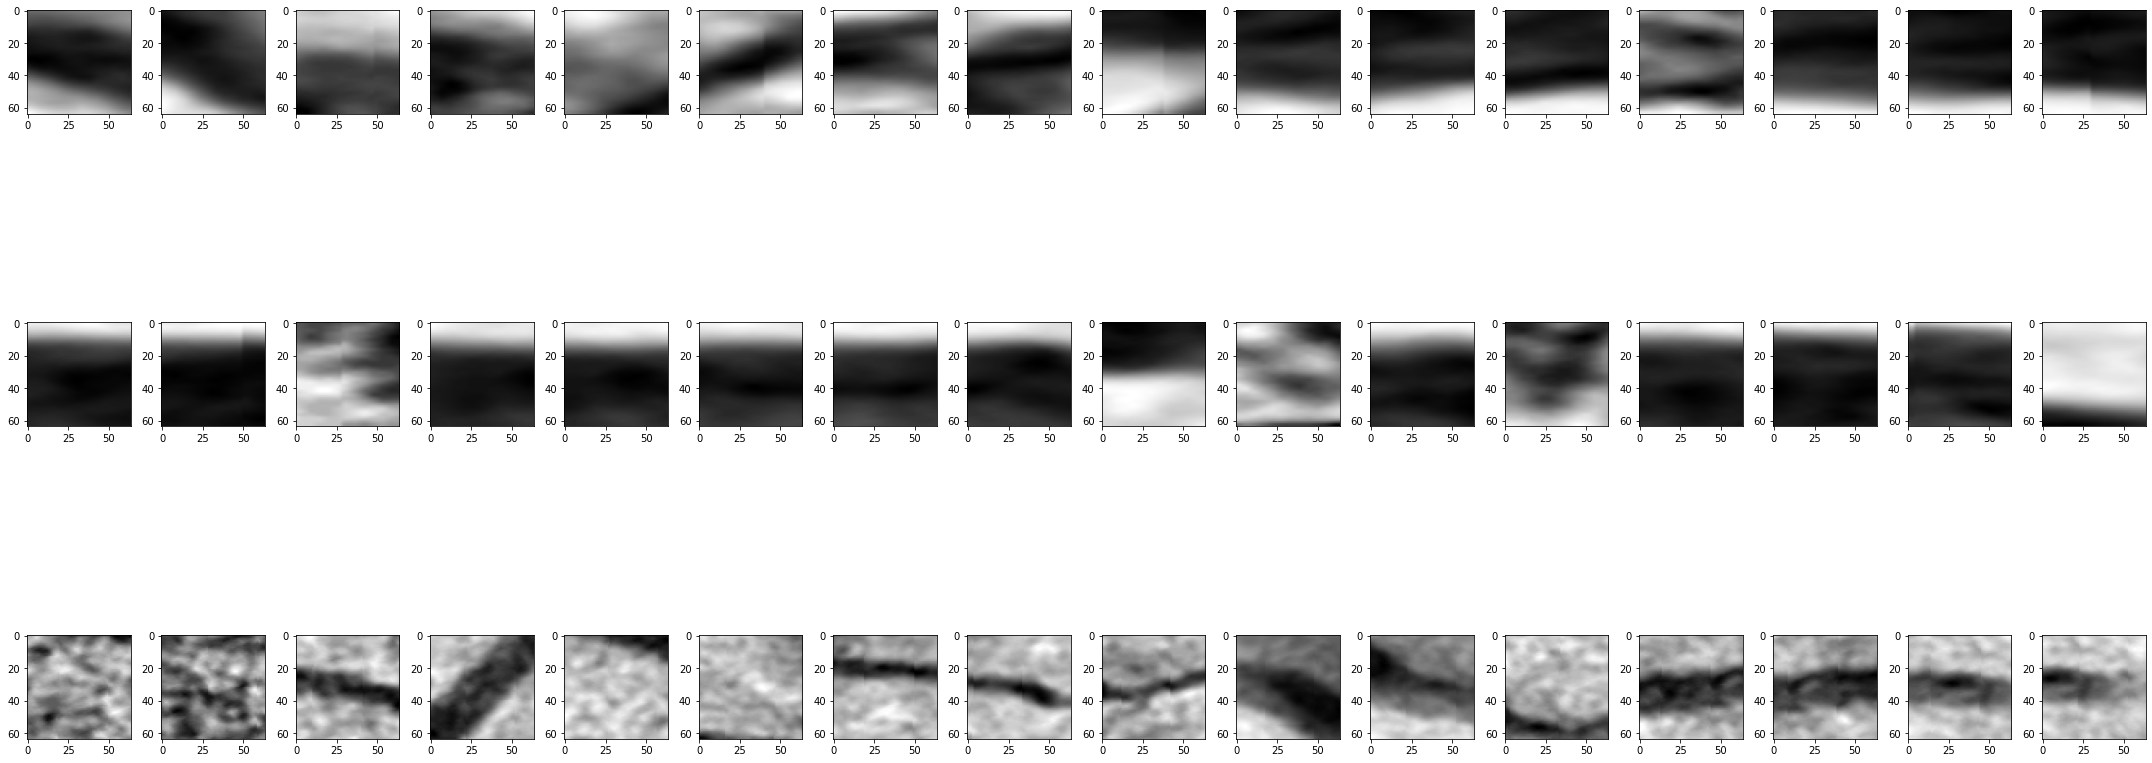



Artery RCA view 1:



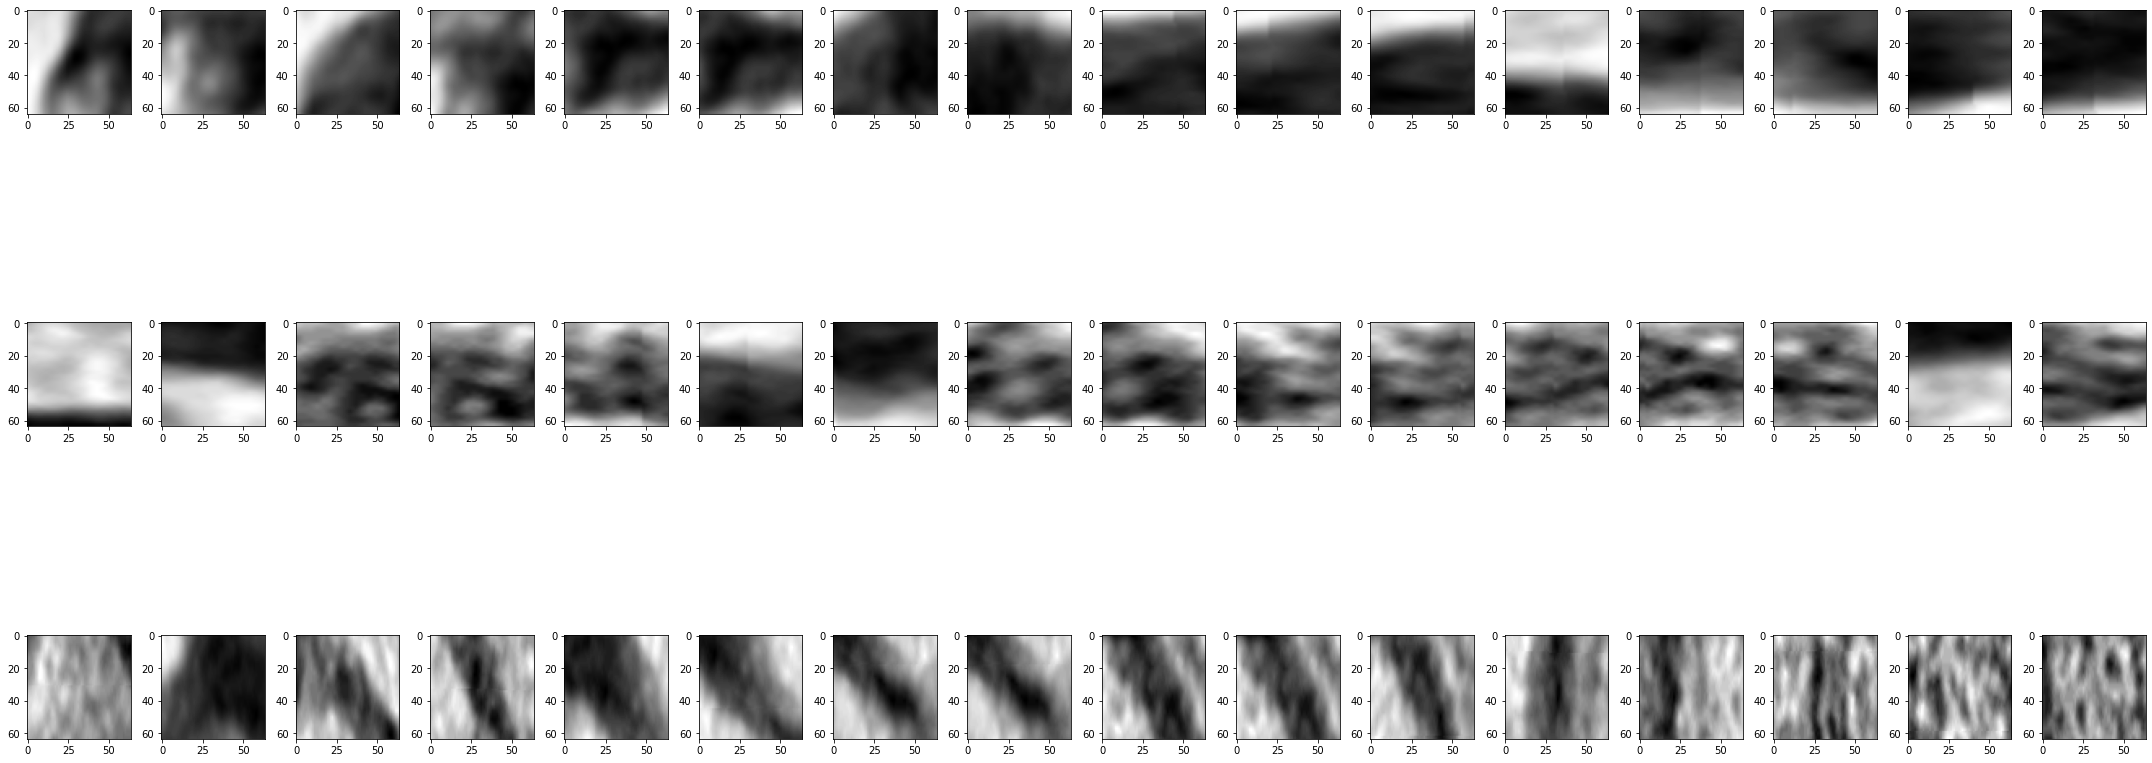

In [80]:
for i_art, artery in enumerate(["LAD", "LCX", "RCA"]):
    if available_arteries[i_art]:
        for i_view in range(0,2):
            print("\n\nArtery {} view {}:\n".format(artery, i_view))
            figure, axis = plt.subplots(len(patches[i_art][i_view])//16, 16, figsize=(30,15))
            for i in range(0, len(patches[i_art][i_view])):
                axis[i//16, i%16].imshow(patches[i_art][i_view][i][0,:,:], cmap="gray")
            figure.tight_layout()
            plt.show()

----